In [1]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip3 install tdmclient --upgrade

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import IPython
from IPython.display import display, clear_output
import time
import math
from cvision import *
from Global_NAV import *

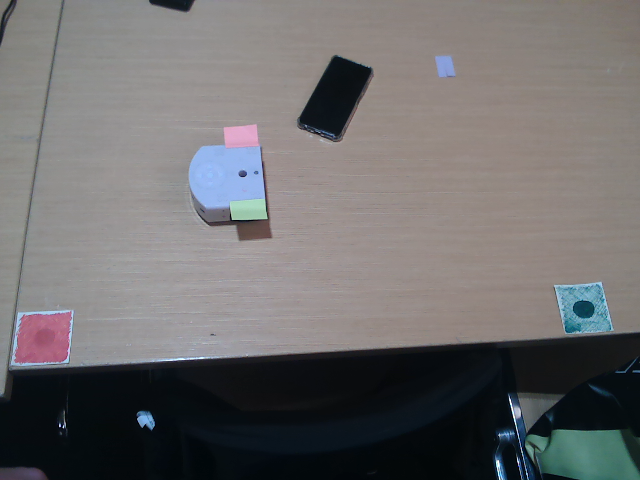

In [27]:
i = 0
cap = cv2.VideoCapture(i)
# Check if camera opened successfully
""" while not cap.isOpened():
    cap = cv2.VideoCapture(i)
    print(f"No camera found at index {i}.")
    i += 1
 """
video_imgs = []
titles = []


for i in range(500):
    ret, frame = cap.read()
    if ret == True:
        video_imgs.append(frame)

        show_frame(frame)
        #time.sleep(1)

        clear_output(wait=True)

frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
   
size = (frame_width, frame_height)
video = cv2.VideoWriter('test3.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
for f in range(len(video_imgs)):
    video.write(video_imgs[f])


        

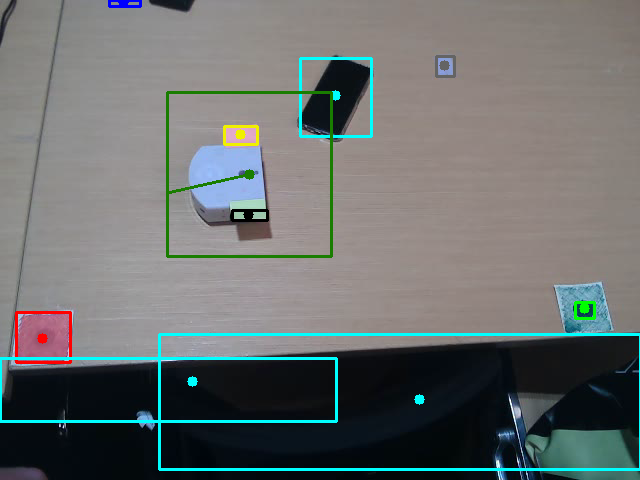

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Robot position :  [0.30380339 0.46096994]
Robot direction :  -3.0679232273478574


In [4]:

# Definition of the references used to map the space
color_ref1 = cv2.imread('ref1.jpg')
ref1 = Obj(color_ref1, 50, 2, np.array([[0,0]]))

color_ref2 = cv2.imread('ref2.jpg')
ref2 = Obj(color_ref2, 100, 2, np.array([[0,0]]))

color_ref3 = cv2.imread('ref3.jpg')
ref3 = Obj(color_ref3, 100, 2, np.array([[0,0]]))

map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
color_obstacle = cv2.imread('obstacle.jpg')
obstacle = Obj(color_obstacle, 700, 4)

color_goal = cv2.imread('goal.jpg')
goal = Obj(color_goal, 100, 4)

color_left_mark = cv2.imread('left_mark.jpg')
left_mark = Obj(color_left_mark, 50, 2)

color_right_mark = cv2.imread('right_mark.jpg')
right_mark = Obj(color_right_mark, 50, 2)

thymio = Robot(right_mark, left_mark)

# Open the video
video = cv2.VideoCapture('test3.avi')
if (video.isOpened()== False): 
	print("Error opening video stream or file")

while(video.isOpened()):
		# Capture frame-by-frame
		ret, frame = video.read()
		if ret == True:
				
			# Draw the objects on a copy of the frame 
			copy_f = frame.copy()
			ref1.draw(copy_f,(0, 255, 0))
			ref2.draw(copy_f,(0,0,255))
			ref3.draw(copy_f,(255, 0, 0))
			goal.draw(copy_f, (100,100,100))
			left_mark.draw(copy_f,(0, 0, 0))
			right_mark.draw(copy_f,(0, 240, 240))
			obstacle.draw(copy_f, (255, 255, 0))
			thymio.draw(copy_f, (0, 125, 25))
			#show_frame(frame)
			show_frame(copy_f)

			# Print the map in a matrix format
			print(map.matrix(frame, [obstacle], thymio, goal))
			if np.size(thymio.localize(frame,map)[1], 0) > 0:
				print('Robot position : ', thymio.localize(frame,map)[0])
				print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))
				#time.sleep(0.4)

				clear_output(wait=True)
		
 
	# Break the loop
		else: 
			break


# When everything done, release the video capture object
video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [29]:
cv2.imwrite('objects.jpg',video_imgs[295])

True

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Passed


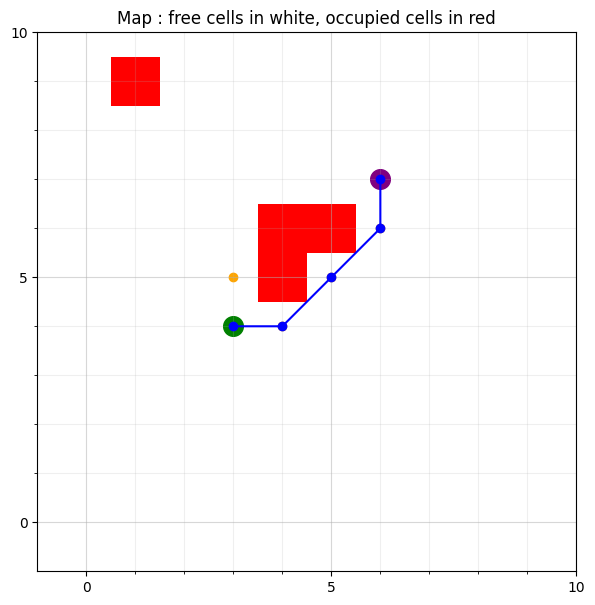

KeyboardInterrupt: 

In [5]:
# Definition of the references used to map the space

color_ref1 = cv2.imread('ref1.jpg')
ref1 = Obj(color_ref1, 50, 2, np.array([[0,0]]))

color_ref2 = cv2.imread('ref2.jpg')
ref2 = Obj(color_ref2, 100, 2, np.array([[0,0]]))

color_ref3 = cv2.imread('ref3.jpg')
ref3 = Obj(color_ref3, 100, 2, np.array([[0,0]]))

map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
color_obstacle = cv2.imread('obstacle.jpg')
obstacle = Obj(color_obstacle, 700, 4)

color_goal = cv2.imread('goal.jpg')
goal = Obj(color_goal, 100, 4)

color_left_mark = cv2.imread('left_mark.jpg')
left_mark = Obj(color_left_mark, 50, 2)

color_right_mark = cv2.imread('right_mark.jpg')
right_mark = Obj(color_right_mark, 50, 2)

thymio = Robot(right_mark, left_mark)

# Open the video
video = cv2.VideoCapture('test3.avi')
if (video.isOpened()== False):
    print("Error opening video stream or file")


while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        # Draw the objects on a copy of the frame 
        """ copy_f = frame.copy()
        ref1.draw(copy_f,(0, 255, 0))
        ref2.draw(copy_f,(0,0,255))
        ref3.draw(copy_f,(255, 0, 0))
        goal.draw(copy_f, (100,100,100))
        left_mark.draw(copy_f,(0, 0, 0))
        right_mark.draw(copy_f,(0, 240, 240))
        obstacle.draw(copy_f, (255, 255, 0))
        thymio.draw(copy_f, (0, 125, 25)) """
        #show_frame(frame)
        #show_frame(copy_f)
        map_mat = map.matrix(frame, [obstacle], thymio, goal)
        print(map_mat)
        if check_matrix(map_mat):
            #print(global_path(map_mat))
            # or
            max_val_x, max_val_y, start, end, arr = conversion(map_mat)
            h, coords = heuristics(max_val_x, max_val_y, end)
            path, visitedNodes = A_Star(start, end, h, coords, arr)
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
            cmap = colors.ListedColormap(['white', 'red'])
            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
            ax_astar.imshow(arr.transpose(), cmap)

            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
            ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200)
            plt.title("best path in blue, visited nodes in orange")
            plt.title("Map : free cells in white, occupied cells in red")
            plt.show()
            time.sleep(1)
        
        clear_output(wait=True)
    # Break the loop
    else:
        break

# When everything done, release the video capture object
video.release()

# Closes all the frames
cv2.destroyAllWindows()